# **Development of an Algorithm for Vehicle Detection and Counting and Watermarking**
**Notebook creado por [Marlon Tecotl](https://www.linkedin.com/in/marlon-tecotl/) para el Master en [Vision Artificial](https://www.techtitute.com/informatica/master/master-vision-artificial) en [Tech](https://www.techtitute.com/) (2024).**

Nuestra empresa de desarollo de algoritmos basados en visión artificial ha recibido un pedido  por parte de la dirección general de tráfico para detectar vehiculos con una camara instalada en un puente de la autopista. Su idea es poder contar cuantos coches circulan diariamente por alli para poder analizar estadisticamente si esa via va muy saturada o no. Con los resultados esperan poder dar peso al arranque de un proyecto para ampliar los carriles de esta via. 

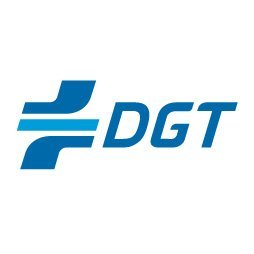

Además nos piden que insertemos una marca de agua con el logo de la dgt, ya que esta cámara y el algoritmo que vamos a desarollar sera accesible via web desde la pagina web de la dgt.

Para el desarollo del algoritmo se nos han entregado 6 imagenes, una llamada background que es nuestra base para el algoritmo donde aparece la autopista sin ningun vehiculo y otras 5 imagenes con vehiculos circulando.
Empezaremos con una idea muy simple que es la extracción del fondo utilizando operaciones aritmeticas con imagenes.



In [2]:
# importamos las libreiras
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8, 8]
import cv2
import numpy as np
import os

En primer lugar vamos a cargar todas las imagenes y mostrar-las usando matplotlib. Como podreis ver la primera imagen muestra la autopista sin coches y la ultima el logo de la dgt.

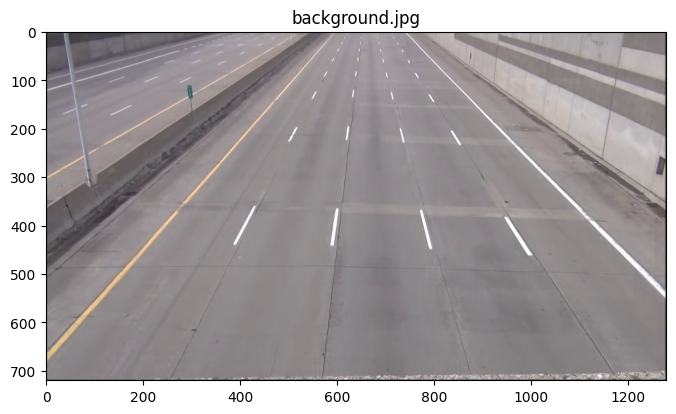

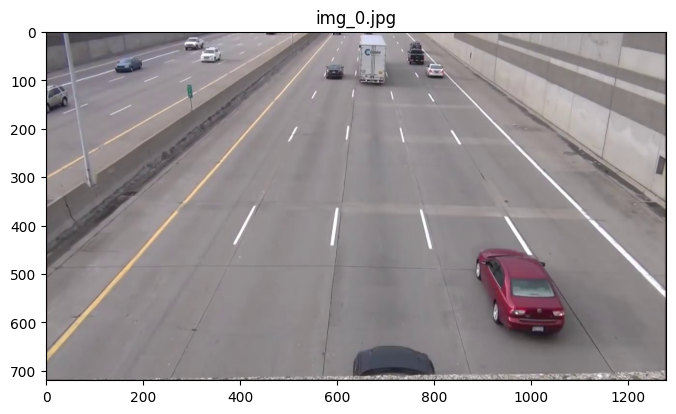

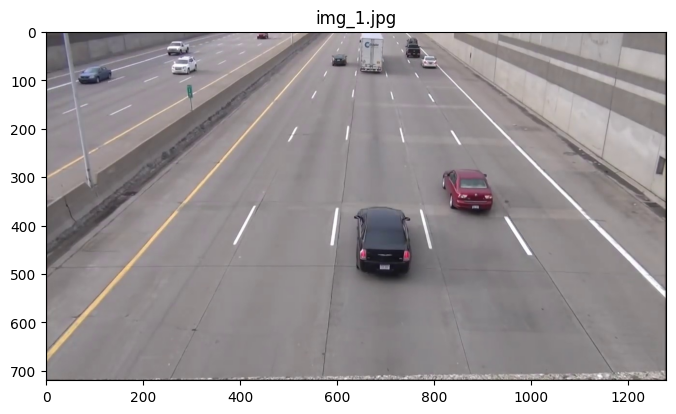

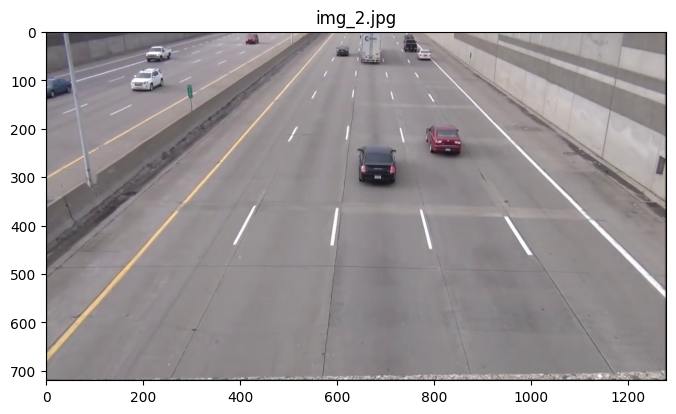

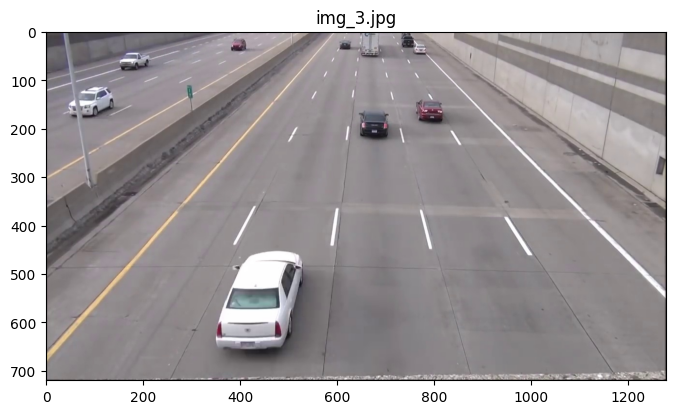

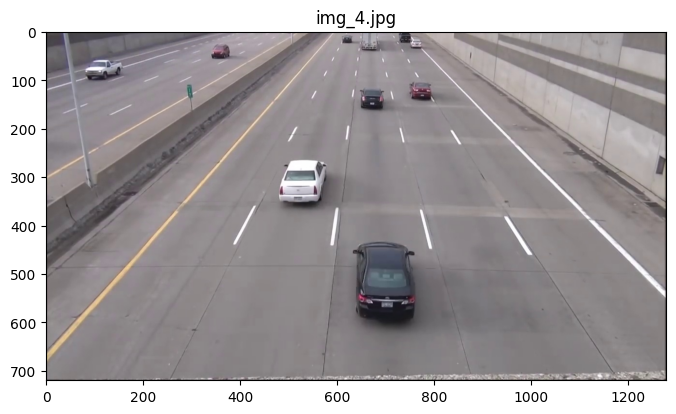

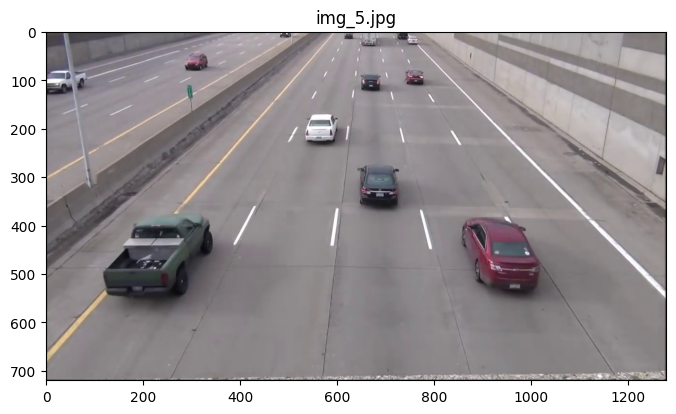

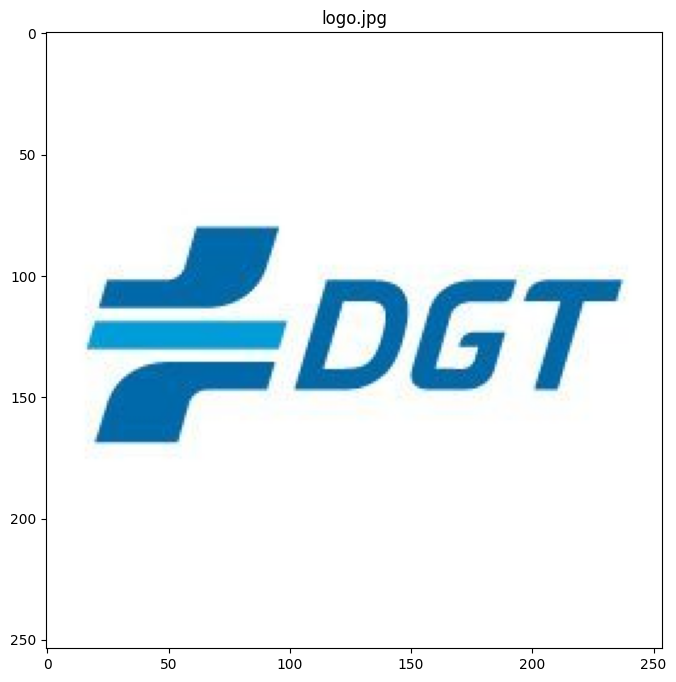

In [3]:
# ruta
images_path = 'data/highway'

# obtenemos los archivos
files = sorted(os.listdir(images_path))

# array para guardar las imagenes de entrada
input_images = []

# recorremos los archivos
for file in files:

  # cargamos la imagen y la añadimos a la lista
  input_images.append({'image': cv2.cvtColor(cv2.imread(os.path.join(images_path, file)), cv2.COLOR_RGB2BGR),
                       'name': file})
  
  plt.title(file)
  plt.imshow(input_images[-1]['image'])
  plt.show()  

## **Substracción del fondo**
A continuación se os entraga un metodo ya implementado que permite extraer el fondo utilizando una imagen de referencia y hace un plot con la imagen y su nombre.

In [4]:
def background_substraction(input_image, name, bkg_image):

    # calculamos la diferencia absoluta
    output_image = cv2.absdiff(cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY),
                               cv2.cvtColor(bkg_image, cv2.COLOR_RGB2GRAY))
    
    # Binarizamos automaticamente con el algoritmo OTSU
    T, output_image = cv2.threshold(output_image, 0, 255,
                                     cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # mostramos la imagen
    plt.title(name)
    plt.imshow(output_image, cmap= 'gray')
    plt.show()

    # devolvemos la imagen
    return output_image

A continuación se pide utilizando el metodo anterior substraer el fondo de todas las imagenes y mostrarlas. Crear una lista con un diccionario con las imagenes y el nombre del archivo. El resultado esperado seria como el siguiente:

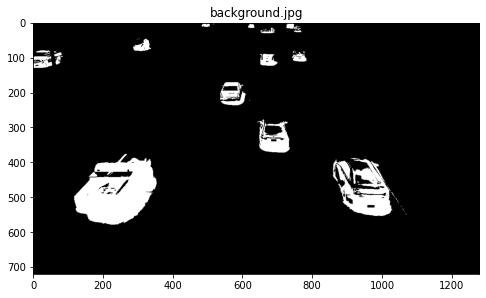

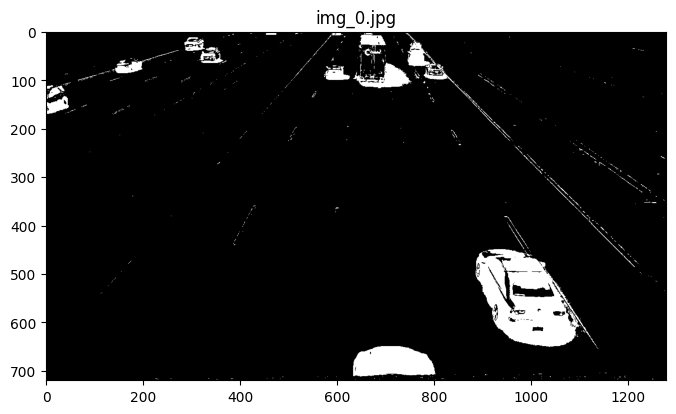

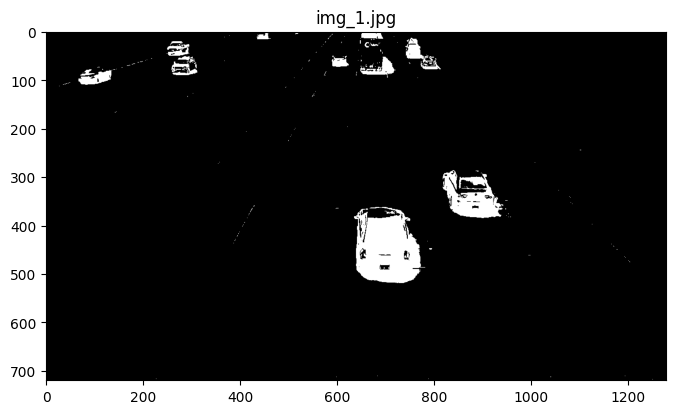

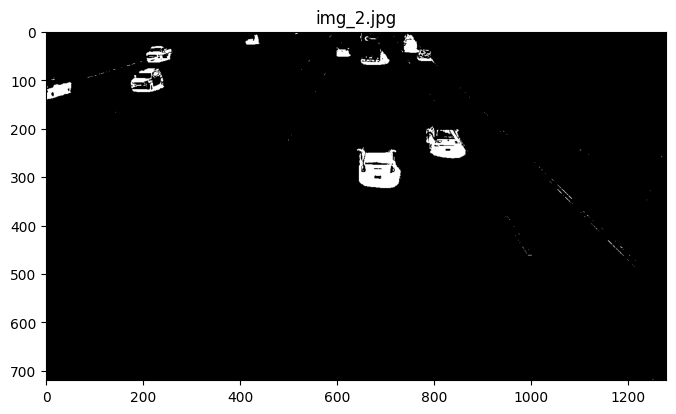

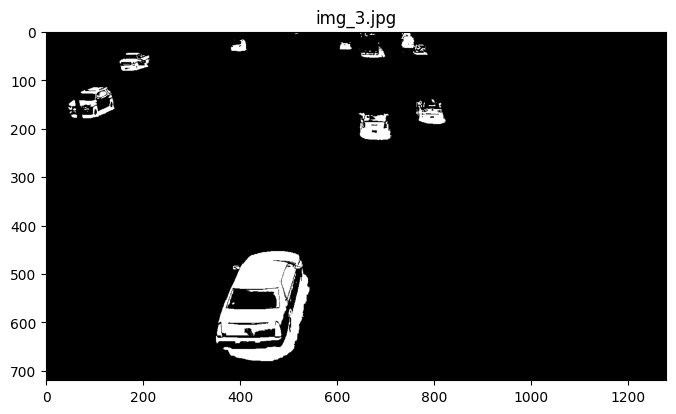

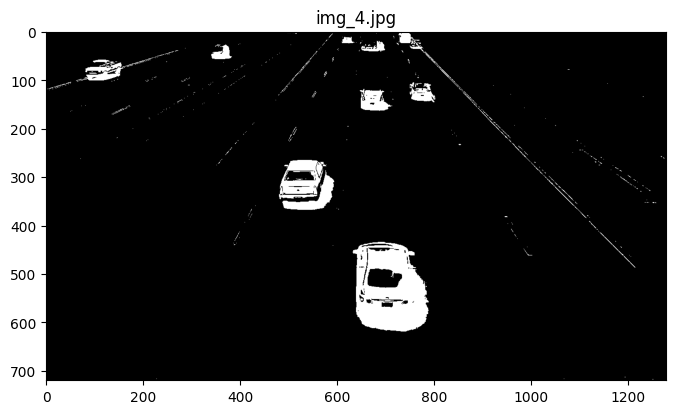

In [5]:
# lista para guardar las imagenenes de salida y los nombres
background_images = []

# imagen inicial
start_image = 1

# recorremos los archivos
for i in range(start_image,len(input_images) - 2):
  bkg_image = background_substraction(input_images[i]['image'], input_images[i]['name'], 
                                      input_images[0]['image'])
  background_images.append({'image': bkg_image,
                       'name': file})

### **Contaje de coches en la imagen**
Una vez hemos conseguido aislar los coches se nos pide que los podamos encontrar en la imagen. Para ello vamos a utilizar el siguiente metodo que nos ha pasado un compañero de trabajo desde nuestro repositorio. Este metodo busca objetos en la imagen entre una area minima y maxima y devuelve la imagen original con los coches encontrados en verde si estan dentro de los limites y en rojo si no.

In [6]:
def find_cars(original_image, background_image, min_area, max_area):
  """Metodo para encontrar coches en la imagen dada la imagen original,
  una imagen de substraccion de fondo, un area minima detectable y un area maxima
  params:
  original_image -> imagen original
  background_image -> imagen del fondo
  min_area -> area minima de objetos a detectar
  max_area -> area maxima de objetos a detectar
  """""

  # copiamos las imagenes que vamos a utilizar
  bkg_image = background_image.copy()
  out_image = original_image.copy()
  
  # aplicamos transformaciones morfologica
  kernel = np.ones((5,5),np.uint8)
  bkg_image = cv2.morphologyEx(bkg_image, cv2.MORPH_OPEN, kernel)
  kernel = np.ones((35,35),np.uint8)
  bkg_image = cv2.morphologyEx(bkg_image, cv2.MORPH_CLOSE, kernel)

  # buscamos los contornos
  contours = cv2.findContours(bkg_image, cv2.RETR_LIST, 
                      cv2.CHAIN_APPROX_SIMPLE)[-2]
  
  xcnts = []
  
  # filter by area  
  for contour in contours:
      if min_area < cv2.contourArea(contour) <= max_area:
          xcnts.append(contour)
          cv2.drawContours(out_image, contour, -1, (0, 255, 0), 3)
      else:
          cv2.drawContours(out_image, contour, -1, (255, 0, 0), 3)
  
  return out_image, bkg_image, len(xcnts)

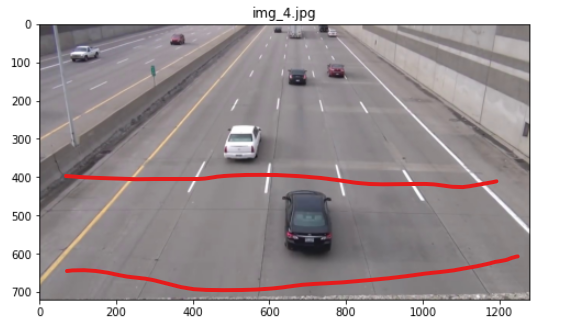

Se pide guardar las imagenes en una lista de salida para poder ser luego enviadas al servidor web del cliente. El resultado esperado seria como el siguiente:

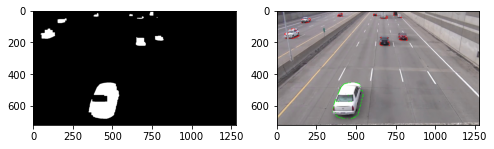

Coches detectados en la imagen = 1


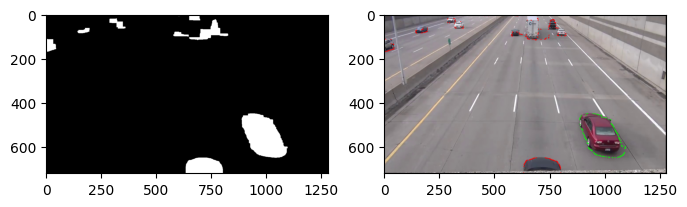

Coches detectados en la imagen = 1


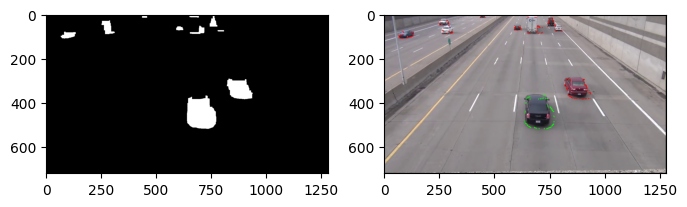

Coches detectados en la imagen = 0


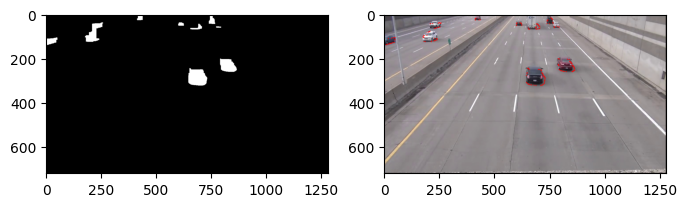

Coches detectados en la imagen = 1


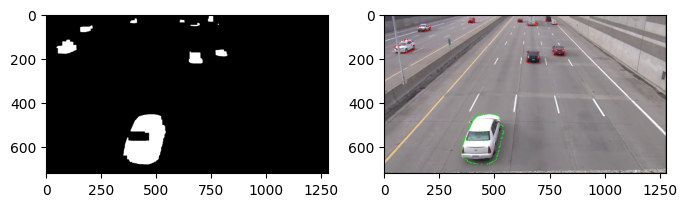

Coches detectados en la imagen = 1


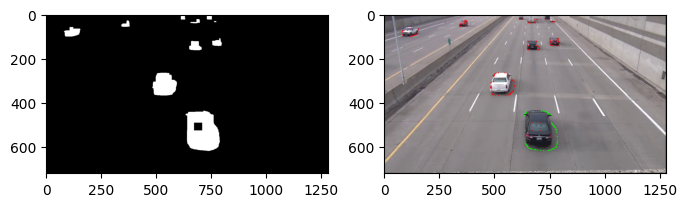

In [9]:
output_images = []

# definimos las areas
area_min = 15000
area_max = 50000

for i in range(len(background_images)):

  # utilizamos el algoritmo de deteccion de coches
  out_image, bkg_image, n_cars = find_cars(input_images[i+1]['image'], 
                                           background_images[i]['image'],
                                           area_min,
                                           area_max)
  
  # agregamos la imagen
  output_images.append(out_image)

  # mostramos los resultados
  print('Coches detectados en la imagen = ' + str(n_cars))
  plt.subplot(121), plt.imshow(bkg_image, cmap= 'gray')
  plt.subplot(122),plt.imshow(out_image, cmap= 'gray')
  plt.show()

## **Marca de agua**
Por ultimo se pide añadir una marca de agua con el logo de la dgt. De esta manera la imagen queda marcada como propiedad de la dgt a la hora de publicarla en el servidor web accesible publicamente. Utilizar el metodo cv2.addweighted(). El resultado esperado es como el siguiente.


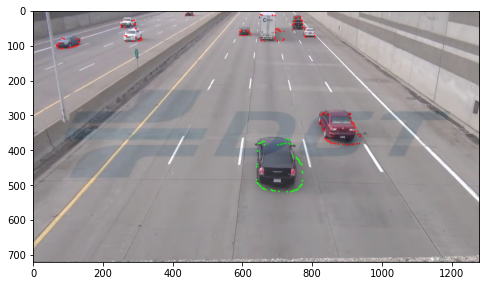

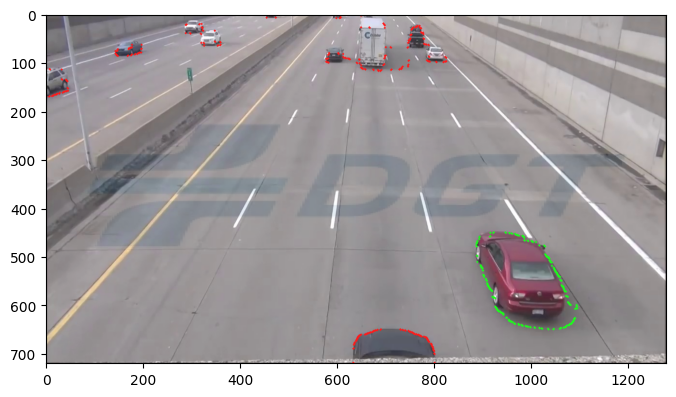

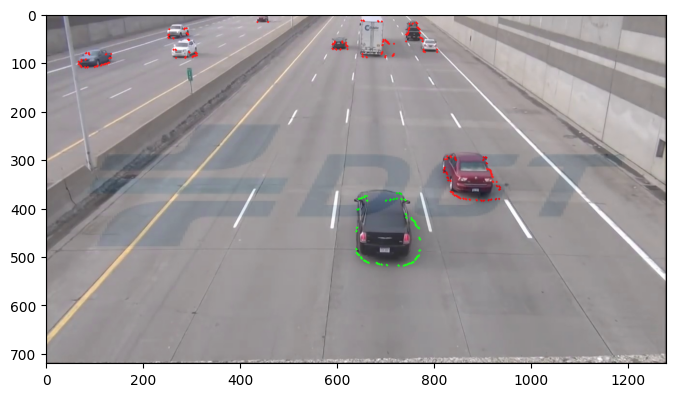

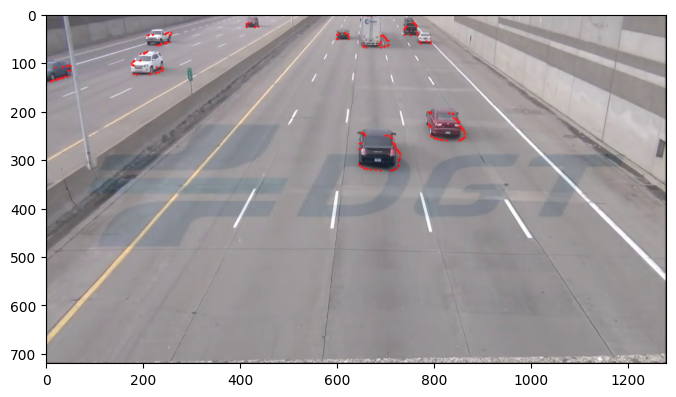

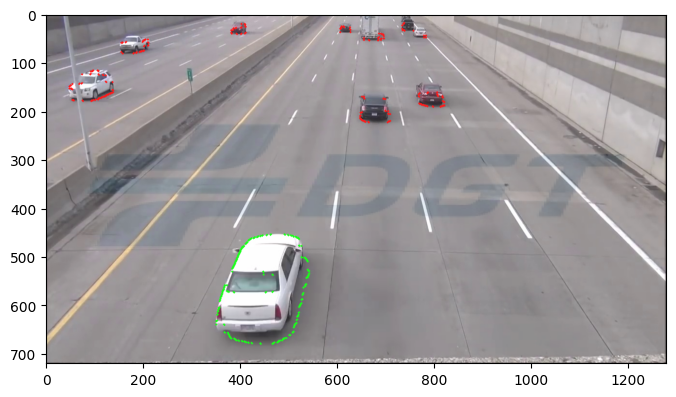

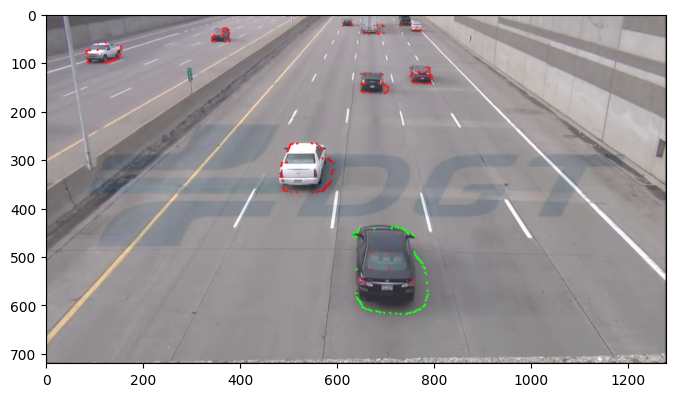

In [8]:
# imagen inicial
start_image = 0

for i in range(start_image,len(output_images)):

  # cambiamos el tamaño a la imagen del logo
  logo_resized = cv2.resize(input_images[7]['image'], output_images[i].shape[1::-1], interpolation = cv2.INTER_AREA)

  # sumamos las imagenes
  out_image = cv2.addWeighted(output_images[i], 0.9, logo_resized, 0.1, 0)
  
  # mostramos resultado
  plt.imshow(out_image)
  plt.show()